In [1]:
import numpy as np
np.set_printoptions(suppress=True)
import h5py
import pandas as pd
from scipy.interpolate import interp1d
import scipy as sp
import pickle
import glob
import cv2
import pykalman
import seaborn as sns
#sns.set()
import scipy.io as sio
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from joblib import dump, load
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, HuberRegressor
from sklearn.model_selection import GridSearchCV
from scipy.optimize import linear_sum_assignment
from scipy.signal import savgol_filter, savgol_coeffs
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from mpl_toolkits.mplot3d import Axes3D  
%matplotlib notebook
import time
%load_ext autoreload
import os
%autoreload 2



# Inputs and explanation

In [2]:
# set the folder containing the calibration information
calibration_folder_path = '/home/thomasreus/Documents/Project/LargeCrop/20200325_calibration/shared_20200907/'

We will read in image coordinates and measured coordinates from this folder. 

We will then regress 5 functions in total, and save them to a new subfolder called 'python_calibration_models'

(1) imCoords_to_XYZ.joblib  

(2) xy_yz_to_xz.joblib  

(3) XYZ_to_imCoords.joblib  

(4) xz_xy_to_yz.joblib 

(5) xz_yz_to_xy.joblib

# Load the calibration information

In [3]:
# As long as Tatsuos naming conventions remain the same, there should be no need to adjust filepaths

#########################
# Names in file changed #
#########################

In [4]:
# set the folder containing the calibration information
measured_coord_folder = os.path.join(calibration_folder_path, 'measured_coords/')
image_coord_folder = os.path.join(calibration_folder_path, 'image_coords/')



# make a list of the text files we need to read from each position folder
imcoord_textfileNames = ['Ex_data_corner.txt', 'Ex_data.txt', 'Ez_data_corner_fixed.txt', 'Ez_data_fixed.txt', \
                         'Fx_data_corner.txt', 'Fx_data.txt', 'Fy_data_corner_fixed.txt', 'Fy_data_fixed.txt', \
                         'Gy_data_corner.txt', 'Gy_data.txt', 'Gz_data_corner_fixed.txt', 'Gz_data_fixed.txt']

measured_textfileNames = ['pos1_measured.txt', 'pos1corner_measured.txt',
                          'pos2_measured.txt', 'pos2corner_measured.txt',
                          'pos3_measured.txt', 'pos3corner_measured.txt',
                          'pos4_measured.txt', 'pos4corner_measured.txt']


position_names = ['rotation1', 'rotation2', 'rotation3', 'rotation4']
# measured_position_names = ['pos1', 'pos2', 'pos3', 'pos4']





# load the measured coordinates
measured_coordinates = []
for i in range(0, len(measured_textfileNames), 2):
    # get paths
    non_corner_path = os.path.join(measured_coord_folder, measured_textfileNames[i])
    corner_path = os.path.join(measured_coord_folder, measured_textfileNames[i+1])
    # load the data
    non_corner_data = np.loadtxt(non_corner_path)
    corner_data = np.loadtxt(corner_path)
    # combine the two
    position_measured_coords = np.concatenate((non_corner_data, corner_data))
    # record
    measured_coordinates.append(position_measured_coords)
full_measured_coordinates = np.vstack(measured_coordinates)


# load the image coordinates
xz_imCoords = []
xy_imCoords = []
yz_imCoords = []

for positionIdx in range(4):
    folder_name = os.path.join(image_coord_folder, position_names[positionIdx])
    
    Ex_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[0]))
    Ex_non_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[1]))
    Ez_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[2]))
    Ez_non_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[3]))
    Ex_data = np.concatenate((Ex_non_corner_data, Ex_corner_data))
    Ez_data = np.concatenate((Ez_non_corner_data, Ez_corner_data))
    
    Fx_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[4]))
    Fx_non_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[5]))
    Fy_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[6]))
    Fy_non_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[7]))
    Fx_data = np.concatenate((Fx_non_corner_data, Fx_corner_data))
    Fy_data = np.concatenate((Fy_non_corner_data, Fy_corner_data))
    
    Gy_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[8]))
    Gy_non_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[9]))
    Gz_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[10]))
    Gz_non_corner_data = np.loadtxt(os.path.join(folder_name, imcoord_textfileNames[11]))
    Gy_data = np.concatenate((Gy_non_corner_data, Gy_corner_data))
    Gz_data = np.concatenate((Gz_non_corner_data, Gz_corner_data))
    
    # Combine the two arrays for each cam
    # BIG DANGER OF A SWAP! e.g (Ex,Ez), or (Ez,Ex)
    # WE WANT OPENCV FORMAT I THINK?
    xz_data = np.stack([Ex_data, Ez_data], axis=1)
    xy_data = np.stack([Fx_data, Fy_data], axis=1)
    yz_data = np.stack([Gy_data, Gz_data], axis=1)
    
    # record for this position
    xz_imCoords.append(xz_data)
    xy_imCoords.append(xy_data)
    yz_imCoords.append(yz_data)
    
# combine the data for each position
xz_imCoords = np.concatenate(xz_imCoords)
xy_imCoords = np.concatenate(xy_imCoords)
yz_imCoords = np.concatenate(yz_imCoords)

# combine into master array
full_image_coordinates = np.stack([xz_imCoords, xy_imCoords, yz_imCoords], axis=0)


print('-- Full Measured Coordinates --')
print('(numBalls, 3D_coord)')
print(full_measured_coordinates.shape)
print()
print('-- Full Image coordinates --')
print('(numCams, numBalls, 2D_coord)')
print(full_image_coordinates.shape)

total_numBalls = full_measured_coordinates.shape[0]
print(total_numBalls)

-- Full Measured Coordinates --
(numBalls, 3D_coord)
(200, 3)

-- Full Image coordinates --
(numCams, numBalls, 2D_coord)
(3, 200, 2)
200


In [5]:
# load the raw images (if you like - not necessary for regressing functions)
raw_image_folder = '/home/thomasreus/Documents/Project/LargeCrop/20200325_calibration/shared_20200907/raw_images'

image_extensions = ['xz_rotation1.tif', 'xz_rotation2.tif', 'xz_rotation3.tif', 'xz_rotation4.tif',
                    'xy_rotation1.tif', 'xy_rotation2.tif', 'xy_rotation3.tif', 'xy_rotation4.tif',
                    'yz_rotation1.tif', 'yz_rotation2.tif', 'yz_rotation3.tif', 'yz_rotation4.tif',
                    ]

image_filepaths = [os.path.join(raw_image_folder, image_extension) for image_extension in image_extensions]


# load the images as a list
images = []
for imPath in image_filepaths:
    images.append(plt.imread(imPath))
    
# turn into an array of shape (numCams, numRotations, 1024, 1280)
calibration_images = np.stack(images)
calibration_images = calibration_images.reshape(3,4,1024,1280)

calibration_images.shape

(3, 4, 1024, 1280)

<IPython.core.display.Javascript object>


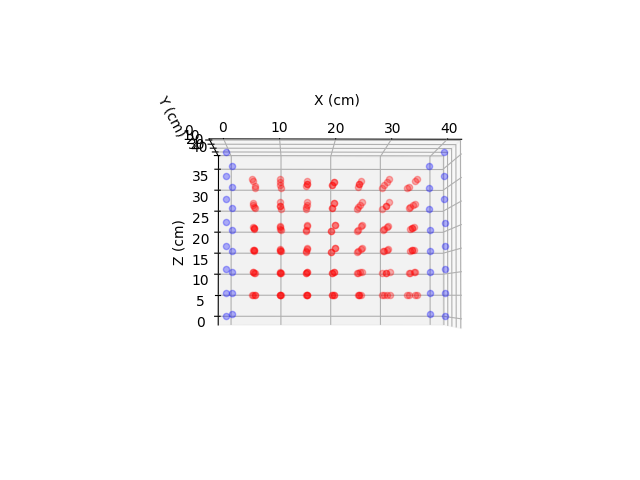

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0.5, 0, 'Z (cm)')

In [6]:
# parse the image coordinates - we only want to use calibration balls which lie within the interior volume

def is_within_interior_cage(XYZ):
    ''' Return True if this 3D values is within the iterior cage,
        False otherwise
    '''
    # define the X, Y and Z ranges of the iterior cage
    iterior_cage_lims = np.array([[5,35],[5,35],[0,32]])
    # preallocate a list to hold the success for the checking of each dimension
    dim_successes = [False]*3
    # check each dimension, does component lie within the cage component limits?
    for i,dim_range in enumerate(iterior_cage_lims):
        if dim_range[0] <= XYZ[i] <= dim_range[1]:
            dim_successes[i] = True
    # If all 3 are successes, then we return True
    if np.all(dim_successes):
        return True
    else:
        return False
    
    
new_meas_list = []
new_im_list = []
within_mask = np.zeros((total_numBalls,), dtype=bool)

for ballIdx in range(total_numBalls):
    if is_within_interior_cage(full_measured_coordinates[ballIdx]):
        new_meas_list.append(full_measured_coordinates[ballIdx])
        new_im_list.append(full_image_coordinates[:,ballIdx])
        within_mask[ballIdx] = True
        
        
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.scatter(full_measured_coordinates[within_mask,0], 
           full_measured_coordinates[within_mask,1], 
           full_measured_coordinates[within_mask,2], 
           marker='o', c=[1,0,0,0.3], depthshade=False)
ax.scatter(full_measured_coordinates[~within_mask,0], 
           full_measured_coordinates[~within_mask,1], 
           full_measured_coordinates[~within_mask,2], 
           marker='o', c=[0,0,1,0.3], depthshade=False)
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_zlabel('Z (cm)')


# fig.savefig("calibration.png", dpi=300)


In [8]:
# Now define measured and image coordinates to only use interior points
measured_coordinates = full_measured_coordinates[within_mask]
image_coordinates = full_image_coordinates[:, within_mask]

print(measured_coordinates.shape)
print(image_coordinates.shape)

numBalls = measured_coordinates.shape[0]
print(numBalls)

(168, 3)
(3, 168, 2)
168


# 2cams to 3rd cam

In [7]:
# prepare the image coordinates 
xz_xy_image_coordinates = np.copy(image_coordinates[:2,:,:].swapaxes(0,1).reshape(numBalls, -1))
xy_yz_image_coordinates = np.copy(image_coordinates[1:,:,:].swapaxes(0,1).reshape(numBalls, -1))
xz_yz_image_coordinates = np.copy(image_coordinates[::2,:,:].swapaxes(0,1).reshape(numBalls, -1))

xz_image_coordinates = np.copy(image_coordinates[0,:,:])
xy_image_coordinates = np.copy(image_coordinates[1,:,:])
yz_image_coordinates = np.copy(image_coordinates[2,:,:])

print(xz_xy_image_coordinates.shape)
print(xy_yz_image_coordinates.shape)
print(xz_yz_image_coordinates.shape)
print()
print(xz_image_coordinates.shape)
print(xy_image_coordinates.shape)
print(yz_image_coordinates.shape)



(168, 4)
(168, 4)
(168, 4)

(168, 2)
(168, 2)
(168, 2)


## XZ&XY to YZ

In [9]:
# STEP1: DETERMINE ALPHA

alpha = [1e-10, 1e-7, 1e-6, 1e-4, 1e-5, 1e-3, 0.001, 0.01, 0.1, 1]
parameters = {'alpha': alpha}

ridge = Ridge(normalize=True)
polyDeg = 3

poly_reg = PolynomialFeatures(degree=polyDeg, include_bias=True)
input_data = poly_reg.fit_transform(xz_xy_image_coordinates)
output_data = np.copy(yz_image_coordinates)

yz_getter = GridSearchCV(ridge, parameters, cv=5)
yz_getter.fit(input_data, output_data)

print(yz_getter.best_params_)
print(yz_getter.best_score_)


{'alpha': 1e-07}
0.999997079522756


t = 2.5596861839294434 s



<IPython.core.display.Javascript object>


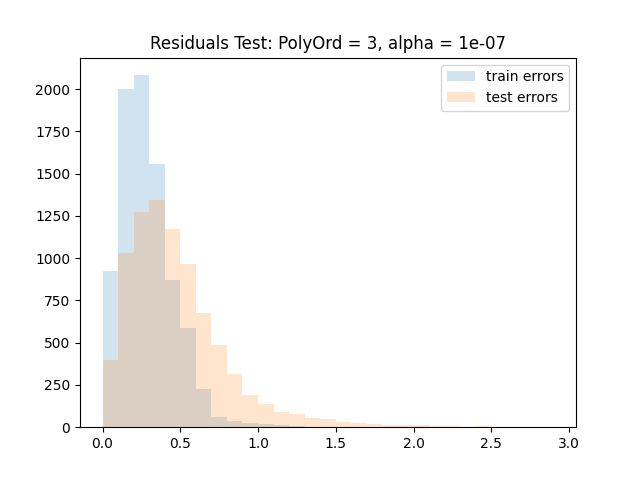

In [9]:
# check for overfitting, and examine the residuals

t0 = time.time()

numPermutations = 100
numTrainingBalls = int(0.5*numBalls)
polyOrders = [3]
numPOrds = len(polyOrders)
alpha=1e-7

train_errors = np.zeros((numPOrds, numPermutations, numTrainingBalls))
test_errors = np.zeros((numPOrds, numPermutations, numBalls-numTrainingBalls))


for polyIdx,polyDeg in enumerate(polyOrders):

    for permIdx in range(numPermutations):

        
        train_ball_idxs = np.random.choice(np.arange(numBalls), size=(numTrainingBalls,1), replace=False).flatten()
        test_ball_idxs = []
        for i in range(numBalls):
            if i not in train_ball_idxs:
                test_ball_idxs.append(i)

        train_image_coordinates = np.copy(xz_xy_image_coordinates[train_ball_idxs])
        test_image_coordinates = np.copy(xz_xy_image_coordinates[test_ball_idxs])

        train_output_coords = np.copy(yz_image_coordinates[train_ball_idxs])
        test_output_coords = np.copy(yz_image_coordinates[test_ball_idxs])

        poly_reg = PolynomialFeatures(degree=polyDeg, include_bias=True)
        input_data = poly_reg.fit_transform(train_image_coordinates)
        output_data = np.copy(train_output_coords)

        yz_getter = Ridge(alpha=alpha, normalize=True)
        yz_getter.fit(input_data, output_data)


        # predict the position of the balls using the models
        calculated_coordinates = np.zeros_like(train_output_coords)
        for ballIdx in range(train_output_coords.shape[0]):
            poly_reg = PolynomialFeatures(degree=polyDeg, include_bias=True)
            prediction_data = poly_reg.fit_transform(train_image_coordinates[ballIdx].reshape(1,-1))
            calculated_coordinates[ballIdx] = yz_getter.predict(prediction_data)
        # look at the size of the errors
        errs = np.linalg.norm(train_output_coords - calculated_coordinates, axis=1)
        train_errors[polyIdx, permIdx, :] = errs


        # predict the position of the balls using the models
        calculated_coordinates = np.zeros_like(test_output_coords)
        for ballIdx in range(test_output_coords.shape[0]):
            poly_reg = PolynomialFeatures(degree=polyDeg, include_bias=True)
            prediction_data = poly_reg.fit_transform(test_image_coordinates[ballIdx].reshape(1,-1))
            calculated_coordinates[ballIdx] = yz_getter.predict(prediction_data)
        # look at the size of the errors
        errs = np.linalg.norm(test_output_coords - calculated_coordinates, axis=1)
        test_errors[polyIdx, permIdx, :] = errs
        
        
te = time.time()
print('t = {0} s'.format(te-t0))
print()



# Residuals plot
train_errors = train_errors.reshape(numPOrds, -1)
test_errors = test_errors.reshape(numPOrds, -1)

bins = np.arange(0, 3, 0.1)

for polyIdx in range(numPOrds):
    plt.figure()
    plt.title('Residuals Test: PolyOrd = {0}, alpha = {1}'.format(polyOrders[polyIdx], alpha))
    plt.hist(train_errors[polyIdx], label='train errors', bins=bins, alpha=0.2);
    plt.hist(test_errors[polyIdx], label='test errors', bins=bins, alpha=0.2);
    plt.legend()


In [10]:
# Fit and save the final model with polyOrd=3, alpha=1e-6
alpha=1e-7
polyDeg=3

input_data = np.copy(xz_xy_image_coordinates)
output_data = np.copy(yz_image_coordinates)

yz_getter =  make_pipeline(PolynomialFeatures(degree=polyDeg, include_bias=True),
                           Ridge(alpha=alpha, normalize=True))
yz_getter.fit(input_data, output_data)

python_calibration_folderPath = os.path.join(calibration_folder_path, 'python_calibration_models')
os.makedirs(python_calibration_folderPath, exist_ok=True);
yz_getter_name = 'xz_xy_to_yz.joblib'

dump(yz_getter, os.path.join(python_calibration_folderPath, yz_getter_name));


# # load the model
# yz_getter_name = 'xz_xy_to_yz.joblib'

# python_calibration_folderPath = os.path.join(calibration_folder_path, 'python_calibration_models')
# yz_getter = load(os.path.join(python_calibration_folderPath, yz_getter_name));

## XY&YZ to XZ

In [11]:
# STEP1: DETERMINE ALPHA

alpha = [1e-10, 1e-7, 1e-6, 1e-4, 1e-5, 1e-3, 0.001, 0.01, 0.1, 1]
parameters = {'alpha': alpha}

ridge = Ridge(normalize=True)
polyDeg = 3

poly_reg = PolynomialFeatures(degree=polyDeg, include_bias=True)
input_data = poly_reg.fit_transform(xy_yz_image_coordinates)
output_data = np.copy(xz_image_coordinates)

xz_getter = GridSearchCV(ridge, parameters, cv=5)
xz_getter.fit(input_data, output_data)

print(xz_getter.best_params_)
print(xz_getter.best_score_)


{'alpha': 1e-06}
0.9999959573275803


t = 2.67547607421875 s



<IPython.core.display.Javascript object>


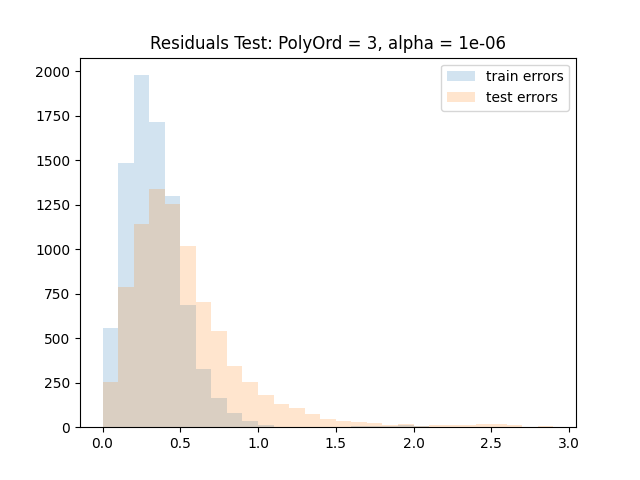

In [13]:
# check for overfitting, and examine the residuals

t0 = time.time()

numPermutations = 100
numTrainingBalls = int(0.5*numBalls)
polyOrders = [3]
numPOrds = len(polyOrders)
alpha=1e-6

train_errors = np.zeros((numPOrds, numPermutations, numTrainingBalls))
test_errors = np.zeros((numPOrds, numPermutations, numBalls-numTrainingBalls))


for polyIdx,polyDeg in enumerate(polyOrders):

    for permIdx in range(numPermutations):

        
        train_ball_idxs = np.random.choice(np.arange(numBalls), size=(numTrainingBalls,1), replace=False).flatten()
        test_ball_idxs = []
        for i in range(numBalls):
            if i not in train_ball_idxs:
                test_ball_idxs.append(i)

        train_image_coordinates = np.copy(xy_yz_image_coordinates[train_ball_idxs])
        test_image_coordinates = np.copy(xy_yz_image_coordinates[test_ball_idxs])

        train_output_coords = np.copy(xz_image_coordinates[train_ball_idxs])
        test_output_coords = np.copy(xz_image_coordinates[test_ball_idxs])

        poly_reg = PolynomialFeatures(degree=polyDeg, include_bias=True)
        input_data = poly_reg.fit_transform(train_image_coordinates)
        output_data = np.copy(train_output_coords)

        xz_getter = Ridge(alpha=alpha, normalize=True)
        xz_getter.fit(input_data, output_data)


        # predict the position of the balls using the models
        calculated_coordinates = np.zeros_like(train_output_coords)
        for ballIdx in range(train_output_coords.shape[0]):
            poly_reg = PolynomialFeatures(degree=polyDeg, include_bias=True)
            prediction_data = poly_reg.fit_transform(train_image_coordinates[ballIdx].reshape(1,-1))
            calculated_coordinates[ballIdx] = xz_getter.predict(prediction_data)
        # look at the size of the errors
        errs = np.linalg.norm(train_output_coords - calculated_coordinates, axis=1)
        train_errors[polyIdx, permIdx, :] = errs


        # predict the position of the balls using the models
        calculated_coordinates = np.zeros_like(test_output_coords)
        for ballIdx in range(test_output_coords.shape[0]):
            poly_reg = PolynomialFeatures(degree=polyDeg, include_bias=True)
            prediction_data = poly_reg.fit_transform(test_image_coordinates[ballIdx].reshape(1,-1))
            calculated_coordinates[ballIdx] = xz_getter.predict(prediction_data)
        # look at the size of the errors
        errs = np.linalg.norm(test_output_coords - calculated_coordinates, axis=1)
        test_errors[polyIdx, permIdx, :] = errs
        
        
te = time.time()
print('t = {0} s'.format(te-t0))
print()

# Residuals plot
train_errors = train_errors.reshape(numPOrds, -1)
test_errors = test_errors.reshape(numPOrds, -1)

bins = np.arange(0, 3, 0.1)

for polyIdx in range(numPOrds):
    plt.figure()
    plt.title('Residuals Test: PolyOrd = {0}, alpha = {1}'.format(polyOrders[polyIdx], alpha))
    plt.hist(train_errors[polyIdx], label='train errors', bins=bins, alpha=0.2);
    plt.hist(test_errors[polyIdx], label='test errors', bins=bins, alpha=0.2);
    plt.legend()

In [15]:
# Fit and save the final model with polyOrd=3, alpha=1e-6
alpha=1e-6
polyDeg=3
    
input_data = np.copy(xy_yz_image_coordinates)
output_data = np.copy(xz_image_coordinates)

xz_getter =  make_pipeline(PolynomialFeatures(degree=polyDeg, include_bias=True),
                           Ridge(alpha=alpha, normalize=True))
xz_getter.fit(input_data, output_data)

python_calibration_folderPath = os.path.join(calibration_folder_path, 'python_calibration_models')
os.makedirs(python_calibration_folderPath, exist_ok=True);
xz_getter_name = 'xy_yz_to_xz.joblib'

dump(xz_getter, os.path.join(python_calibration_folderPath, xz_getter_name));


# # load the model
# xz_getter_name = 'xy_yz_to_xz.joblib'

# python_calibration_folderPath = os.path.join(calibration_folder_path, 'python_calibration_models')
# xz_getter = load(os.path.join(python_calibration_folderPath, xz_getter_name));

## XZ&YZ to XY

In [12]:
# STEP1: DETERMINE ALPHA

alpha = [1e-10, 1e-7, 1e-6, 1e-4, 1e-5, 1e-3, 0.001, 0.01, 0.1, 1]
parameters = {'alpha': alpha}

ridge = Ridge(normalize=True)
polyDeg = 3

poly_reg = PolynomialFeatures(degree=polyDeg, include_bias=True)
input_data = poly_reg.fit_transform(xz_yz_image_coordinates)
output_data = np.copy(xy_image_coordinates)

xy_getter = GridSearchCV(ridge, parameters, cv=5)
xy_getter.fit(input_data, output_data)

print(xy_getter.best_params_)
print(xy_getter.best_score_)


{'alpha': 1e-06}
0.9999969686650809


t = 2.755899429321289 s



<IPython.core.display.Javascript object>


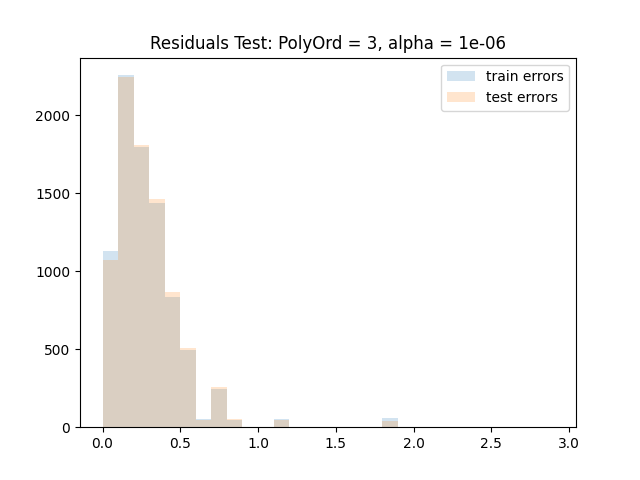

In [17]:
# check for overfitting, and examine the residuals

t0 = time.time()

numPermutations = 100
numTrainingBalls = int(0.5*numBalls)
polyOrders = [3]
numPOrds = len(polyOrders)
alpha=1e-6

train_errors = np.zeros((numPOrds, numPermutations, numTrainingBalls))
test_errors = np.zeros((numPOrds, numPermutations, numBalls-numTrainingBalls))


for polyIdx,polyDeg in enumerate(polyOrders):

    for permIdx in range(numPermutations):

        
        train_ball_idxs = np.random.choice(np.arange(numBalls), size=(numTrainingBalls,1), replace=False).flatten()
        test_ball_idxs = []
        for i in range(numBalls):
            if i not in train_ball_idxs:
                test_ball_idxs.append(i)

        train_image_coordinates = np.copy(xz_yz_image_coordinates[train_ball_idxs])
        test_image_coordinates = np.copy(xz_yz_image_coordinates[test_ball_idxs])

        train_output_coords = np.copy(xy_image_coordinates[train_ball_idxs])
        test_output_coords = np.copy(xy_image_coordinates[test_ball_idxs])

        poly_reg = PolynomialFeatures(degree=polyDeg, include_bias=True)
        input_data = poly_reg.fit_transform(train_image_coordinates)
        output_data = np.copy(train_output_coords)

        xz_getter = Ridge(alpha=alpha, normalize=True)
        xz_getter.fit(input_data, output_data)


        # predict the position of the balls using the models
        calculated_coordinates = np.zeros_like(train_output_coords)
        for ballIdx in range(train_output_coords.shape[0]):
            poly_reg = PolynomialFeatures(degree=polyDeg, include_bias=True)
            prediction_data = poly_reg.fit_transform(train_image_coordinates[ballIdx].reshape(1,-1))
            calculated_coordinates[ballIdx] = xy_getter.predict(prediction_data)
        # look at the size of the errors
        errs = np.linalg.norm(train_output_coords - calculated_coordinates, axis=1)
        train_errors[polyIdx, permIdx, :] = errs


        # predict the position of the balls using the models
        calculated_coordinates = np.zeros_like(test_output_coords)
        for ballIdx in range(test_output_coords.shape[0]):
            poly_reg = PolynomialFeatures(degree=polyDeg, include_bias=True)
            prediction_data = poly_reg.fit_transform(test_image_coordinates[ballIdx].reshape(1,-1))
            calculated_coordinates[ballIdx] = xy_getter.predict(prediction_data)
        # look at the size of the errors
        errs = np.linalg.norm(test_output_coords - calculated_coordinates, axis=1)
        test_errors[polyIdx, permIdx, :] = errs
        
        
te = time.time()
print('t = {0} s'.format(te-t0))
print()



# Residuals plot
train_errors = train_errors.reshape(numPOrds, -1)
test_errors = test_errors.reshape(numPOrds, -1)

bins = np.arange(0, 3, 0.1)

for polyIdx in range(numPOrds):
    plt.figure()
    plt.title('Residuals Test: PolyOrd = {0}, alpha = {1}'.format(polyOrders[polyIdx], alpha))
    plt.hist(train_errors[polyIdx], label='train errors', bins=bins, alpha=0.2);
    plt.hist(test_errors[polyIdx], label='test errors', bins=bins, alpha=0.2);
    plt.legend()


In [19]:
# Fit and save the final model with polyOrd=3, alpha=1e-6
alpha=1e-6
polyDeg=3

input_data = np.copy(xz_yz_image_coordinates)
output_data = np.copy(xy_image_coordinates)

xy_getter = make_pipeline(PolynomialFeatures(degree=polyDeg, include_bias=True),
                        Ridge(alpha=alpha, normalize=True))
xy_getter.fit(input_data, output_data)


# make the folder to hold the models
python_calibration_folderPath = os.path.join(calibration_folder_path, 'python_calibration_models')
os.makedirs(python_calibration_folderPath, exist_ok=True);
xy_getter_name = 'xz_yz_to_xy.joblib'

# save classifier
dump(xy_getter, os.path.join(python_calibration_folderPath, xy_getter_name));



# # load the model
# xy_getter_name = 'xz_yz_to_xy.joblib'

# python_calibration_folderPath = os.path.join(calibration_folder_path, 'python_calibration_models')
# xy_getter = load(os.path.join(python_calibration_folderPath, xy_getter_name));

# 3cam -> XYZ

<IPython.core.display.Javascript object>


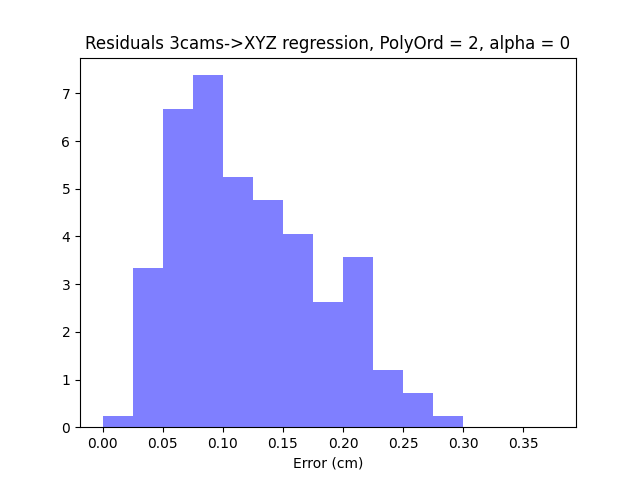

['/home/thomasreus/Documents/Project/LargeCrop/20200325_calibration/shared_20200907/python_calibration_models/imCoords_to_XYZ.joblib']

In [20]:
## CASE 1: Using all the interior balls

t0 = time.time()

input_imCoords = np.copy(image_coordinates)
output_XYZs = np.copy(measured_coordinates)
polyDeg=2
numPOrds = len(polyOrders)
alpha=0

    
    
## ------ FIT THE FINAL MODEL  ----- ##  


input_data = np.copy(input_imCoords.swapaxes(0,1).reshape(-1,6))
output_data = np.copy(output_XYZs)

xyz_getter =  make_pipeline(PolynomialFeatures(degree=polyDeg, include_bias=True),
                               Ridge(alpha=alpha, normalize=True))
xyz_getter.fit(input_data, output_data)




# ----- examine residuals -----------------
input_data = np.copy(image_coordinates.swapaxes(0,1).reshape(-1,6))
calculated_coordinates = xyz_getter.predict(input_data)
errs = np.linalg.norm(measured_coordinates - calculated_coordinates, axis=1)

plt.figure()
plt.title('Residuals 3cams->XYZ regression, PolyOrd = {0}, alpha = {1}'.format(polyDeg,alpha))
bins = np.arange(0,np.max(errs+0.1),0.025)
plt.hist(errs, density=True, color='b', bins=bins, alpha=0.5);
plt.xlabel('Error (cm)')     




# --------- save the models ----------------------------#
# make the folder to hold the models
clf_folderPath = os.path.join(calibration_folder_path, 'python_calibration_models/')
os.makedirs(clf_folderPath, exist_ok=True)
xyz_clf_name = 'imCoords_to_XYZ.joblib'
dump(xyz_getter, os.path.join(clf_folderPath, xyz_clf_name))

# XYZ -> 3cam image coordinates

In [21]:
input_XYZs = np.copy(measured_coordinates)
output_imCoords = np.copy(image_coordinates)

In [22]:
# STEP1: DETERMINE ALPHA

#alpha = [1e-15, 1e-14, 1e-10, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-2, 0.1, 1, 10, 50, 100, 1000]
alpha = [1e-15, 1e-12, 1e-10, 1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1]
#alpha = [6, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 7, 7.2, 7.4]
parameters = {'alpha': alpha}

ridge = Ridge(normalize=True)
polyDeg = 4

poly_reg = PolynomialFeatures(degree=polyDeg, include_bias=True)
input_data = poly_reg.fit_transform(input_XYZs)
output_data = np.copy(output_imCoords.swapaxes(0,1).reshape(-1, 6))

xyz_getter = GridSearchCV(ridge, parameters, cv=4)
xyz_getter.fit(input_data, output_data)

print(xyz_getter.best_params_)
print(xyz_getter.best_score_)

{'alpha': 0.0001}
0.9998944471036


/home/thomasreus/Documents/Project/sleap_env/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.33732e-17): result may not be accurate.
  overwrite_a=True).T
/home/thomasreus/Documents/Project/sleap_env/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.51588e-17): result may not be accurate.
  overwrite_a=True).T
/home/thomasreus/Documents/Project/sleap_env/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.33732e-17): result may not be accurate.
  overwrite_a=True).T
/home/thomasreus/Documents/Project/sleap_env/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.33066e-17): result may not be accurate.
  overwrite_a=True).T


<IPython.core.display.Javascript object>


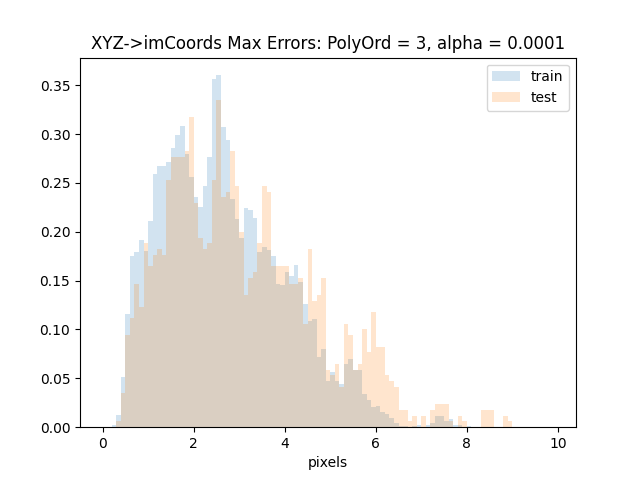

In [23]:
## STEP 2: Test/train

numPermutations = 100
numTrainingFactor = 0.9
polyOrders = [3]
polyDeg = 3
numPOrds = len(polyOrders)
alpha=0.0001

numBalls = input_XYZs.shape[0]
numTrainingBalls = int(numTrainingFactor*numBalls)
train_errors = np.zeros((numPOrds, numPermutations, numTrainingBalls, 3))
test_errors = np.zeros((numPOrds, numPermutations, numBalls-numTrainingBalls, 3))

for polyIdx,polyDeg in enumerate(polyOrders):
    for permIdx in range(numPermutations):

        ## PREPARE THE DATA IN TRAIN/TEST SPLIT FOR THIS REALIZATION
        train_ball_idxs = np.random.choice(np.arange(numBalls), size=(numTrainingBalls,1), replace=False).flatten()
        test_ball_idxs = []
        for i in range(numBalls):
            if i not in train_ball_idxs:
                test_ball_idxs.append(i)
                
        input_XYZs_train = np.copy(input_XYZs[train_ball_idxs])
        input_XYZs_test = np.copy(input_XYZs[test_ball_idxs])
        
        output_imCoords_train = np.copy(output_imCoords[:, train_ball_idxs].swapaxes(0,1).reshape(-1, 6))
        output_imCoords_test = np.copy(output_imCoords[:, test_ball_idxs].swapaxes(0,1).reshape(-1, 6))

        
        ## TRAIN THE MODEL
        poly_reg = PolynomialFeatures(degree=polyDeg, include_bias=True)
        input_data = poly_reg.fit_transform(input_XYZs_train)
        output_data = np.copy(output_imCoords_train)

        imCoord_getter = Ridge(alpha=alpha, normalize=True)
        imCoord_getter.fit(input_data, output_data)
    
        
        
        # EVALUATE TRAINING SET
        errs = np.zeros((output_imCoords_train.shape[0],3))
        calculated_vals = imCoord_getter.predict(poly_reg.fit_transform(input_XYZs_train))
        calculated_vals = calculated_vals.reshape(-1,3,2)
        for ballIdx in range(output_imCoords_train.shape[0]):
            for camIdx in range(3):
                errs[ballIdx, camIdx] = np.linalg.norm(calculated_vals[ballIdx, camIdx] - 
                                                       output_imCoords_train.reshape(-1,3,2)[ballIdx, camIdx])
        train_errors[polyIdx, permIdx, :] = errs
        
        
        # EVALUATE TEST SET
        errs = np.zeros((output_imCoords_test.shape[0],3))
        calculated_vals = imCoord_getter.predict(poly_reg.fit_transform(input_XYZs_test))
        calculated_vals = calculated_vals.reshape(-1,3,2)
        for ballIdx in range(output_imCoords_test.shape[0]):
            for camIdx in range(3):
                errs[ballIdx, camIdx] = np.linalg.norm(calculated_vals[ballIdx, camIdx] - 
                                                       output_imCoords_test.reshape(-1,3,2)[ballIdx, camIdx])
        test_errors[polyIdx, permIdx, :] = errs
        
        

# ## ------ PLOTTING TRAIN/TEST  ----- ##
# Residuals plot
train_errors = train_errors.reshape(numPOrds, -1, 3)
test_errors = test_errors.reshape(numPOrds, -1, 3)

max_train_errors = np.max(train_errors, axis=2)
max_test_errors = np.max(test_errors, axis=2)

plt.figure()
plt.xlabel('pixels')
plt.title('Max Errors')
plt.title('XYZ->imCoords Max Errors: PolyOrd = {0}, alpha = {1}'.format(polyOrders[polyIdx],alpha))
plt.hist(max_train_errors[0, :], density=True, bins=np.arange(0,10,0.1), alpha=0.2, label='train')
plt.hist(max_test_errors[0, :], density=True, bins=np.arange(0,10,0.1), alpha=0.2, label='test')
plt.legend()

<IPython.core.display.Javascript object>


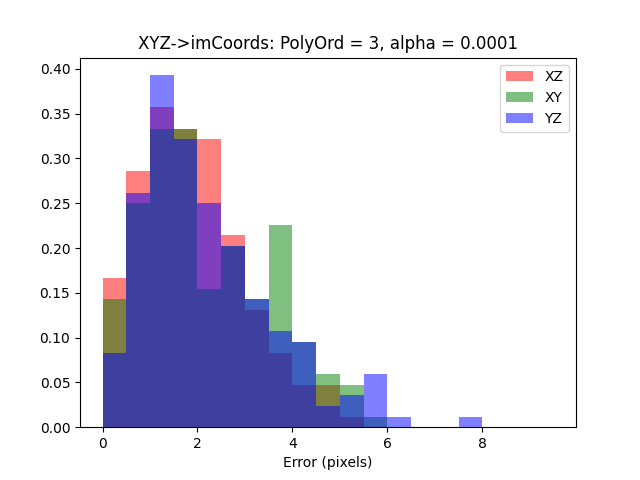

In [24]:
# # ## ------ FIT THE FINAL MODEL  ----- ##  


output_imCoords_all = np.copy(output_imCoords.swapaxes(0,1).reshape(-1, 6))


## TRAIN THE MODEL
input_data = np.copy(input_XYZs)
output_data = np.copy(output_imCoords.swapaxes(0,1).reshape(-1, 6))
imCoord_getter = make_pipeline(PolynomialFeatures(degree=polyDeg, include_bias=True),
                               Ridge(alpha=alpha, normalize=True))
imCoord_getter.fit(input_data, output_data)

## SAVE THE MODEL
clf_folderPath = os.path.join(calibration_folder_path, 'python_calibration_models')
os.makedirs(clf_folderPath, exist_ok=True)
imCoord_clf_name = 'XYZ_to_imCoords.joblib'
dump(imCoord_getter, os.path.join(clf_folderPath, imCoord_clf_name))


# # # ----- examine the full residuals on only the interior balls ------ ###

errs = np.zeros((output_imCoords_all.shape[0],3))
#calculated_vals = imCoord_getter.predict(poly_reg.fit_transform(input_XYZs))
calculated_vals = imCoord_getter.predict(input_XYZs)
calculated_vals = calculated_vals.reshape(-1,3,2)
for ballIdx in range(output_imCoords_all.shape[0]):
    for camIdx in range(3):
        errs[ballIdx, camIdx] = np.linalg.norm(calculated_vals[ballIdx, camIdx] - 
                                               output_imCoords_all.reshape(-1,3,2)[ballIdx, camIdx])
    

plt.figure()
plt.title('XYZ->imCoords: PolyOrd = {0}, alpha = {1}'.format(polyOrders[polyIdx],alpha))
bins = np.arange(0,np.max(errs+2),0.5)
plt.hist(errs[:,0], density=True, color='r', alpha=0.5, bins=bins, label='XZ');
plt.hist(errs[:,1], density=True, color='g', alpha=0.5, bins=bins, label='XY');
plt.hist(errs[:,2], density=True, color='b', alpha=0.5, bins=bins, label='YZ');
plt.xlabel('Error (pixels)')  
plt.legend()